<a href="https://colab.research.google.com/github/titocampos/estudo-crm/blob/master/aula_20200214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo conjunto** #
<https://sigmoidal.ai/data-science-titanic-python-1/>  e
<https://www.kaggle.com/kernels/scriptcontent/6741265/download>


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!rm -rf ~/.kaggle/

### Exploração/Análise de Dados ###

In [115]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# identificar o tipo de cada variável
display(df_train.dtypes)

# ver as 5 primeiras entradas do conjunto de treino
display(df_train.head())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [93]:
# ver a porcentagem valores faltantes
#(df_train.isnull().sum() / df_train.shape[0]).sort_values(ascending=False)

total = df_train.isnull().sum().sort_values(ascending=False)
percent_1 = df_train.isnull().sum()/df_train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(15)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0
Parch,0,0.0
SibSp,0,0.0
Sex,0,0.0
Name,0,0.0
Pclass,0,0.0


In [94]:
#Como é a distribuição estatística dos dados?
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


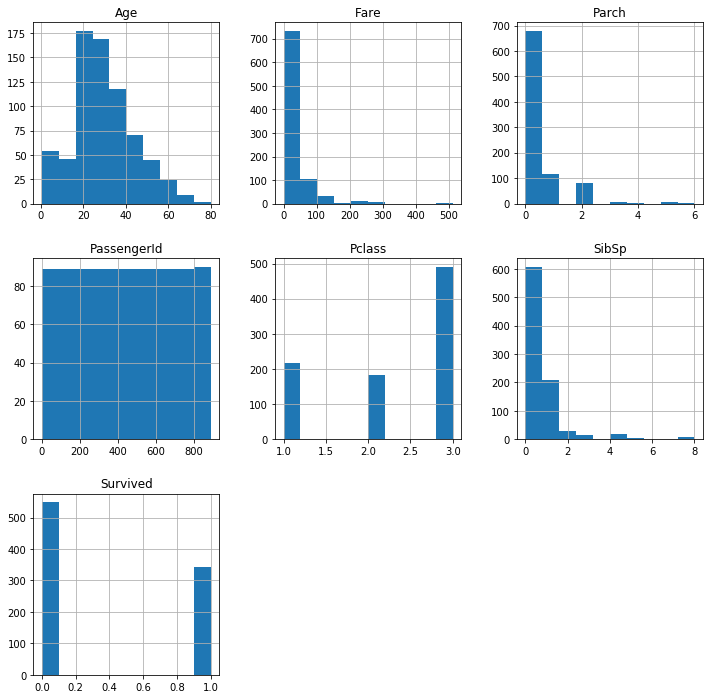

In [95]:
# ver histograma das variáveis numéricas
df_train.hist();

In [96]:
# Analisar a probabilidade de sobrevivência pelo Sexo
df_train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


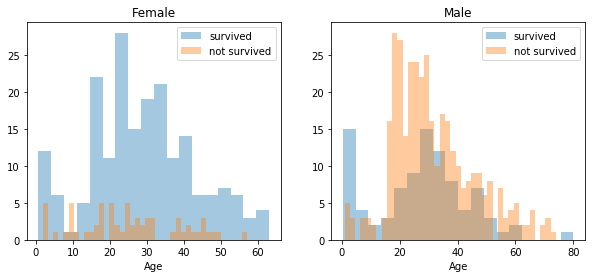

In [97]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = df_train[df_train['Sex']=='female']
men = df_train[df_train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

Você pode ver que os homens têm uma alta probabilidade de sobrevivência quando têm entre 18 e 30 anos, o que também é um pouco verdadeiro para as mulheres, mas não totalmente. Para as mulheres, as chances de sobrevivência são maiores entre 14 e 40 anos.

Para os homens, a probabilidade de sobrevivência é muito baixa entre os 5 e os 18 anos, mas isso não é verdade para as mulheres. Outra coisa a notar é que os bebês também têm uma probabilidade um pouco maior de sobrevivência.

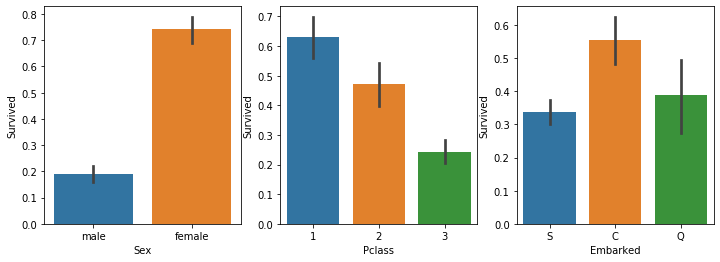

In [98]:
# Plotar os gráficos para Survived vs. Sex, Pclass e Embarked
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(12,4))

sns.barplot(x='Sex', y='Survived', data=df_train, ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=df_train, ax=axis2)
sns.barplot(x='Embarked', y='Survived', data=df_train, ax=axis3);

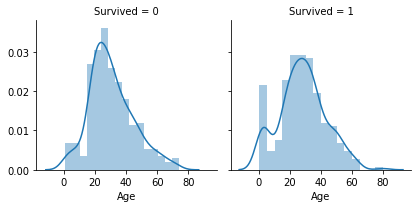

In [11]:
# ver influência da idade na probabilidade de sobrevivência
age_survived = sns.FacetGrid(df_train, col='Survived')
age_survived.map(sns.distplot, 'Age')

Ao analisar também a distribuição das idades dos sobreviventes e mortos, dá para ver um pico no lado dos sobreviventes para crianças pequenas. O comportamento dos dois gráficos é bem parecido, mas esse detalhe é bem importante pois confirma a hipótese que crianças também tem maior chance de sobreviverem: “Crianças e mulheres primeiro”


Pouca gente sabe que o método df.describe() pode ser usado também para ver algo sobre a estatística descritiva em colunas que não são números. Para isso, é só passar o argumento include=['O'].
**ATENÇÃO, é a letra 'O', e não o número zero!**

In [12]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Gee, Mr. Arthur H",male,CA. 2343,G6,S
freq,1,577,7,4,644


Olhando esses dados a gente observa que:

Os valores para Name são únicos, um para cada pessoa;
Não há missing values para Name e Sex;
Existem apenas os sexos Masculino e Feminino, sendo que o com maior frequência é o Masculino (577/891 = 65%);
O Porto no qual embarcaram mais passageiros é o de S = Southampton.

In [116]:
data = [df_train, df_test]

for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)    
    
df_train['not_alone'].value_counts()    

1    537
0    354
Name: not_alone, dtype: int64

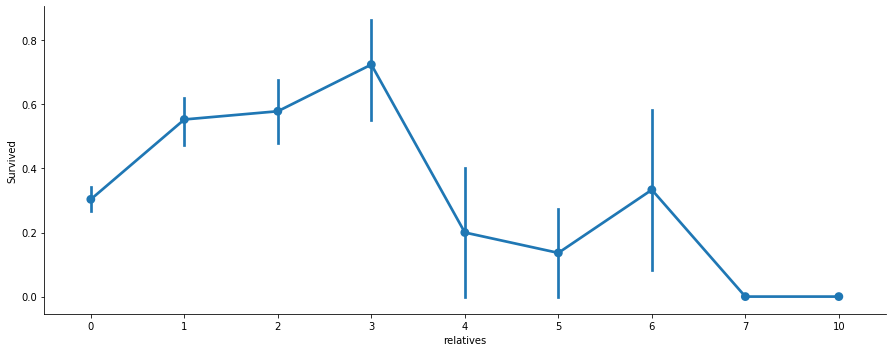

In [100]:
axes = sns.catplot('relatives','Survived', 
                      data=df_train, aspect = 2.5, kind='point')

Aqui podemos ver que temos uma alta probabilidade de sobrevivência com 1 a 3 parentes, mas uma menor probabilidade se você tem menos de 1 ou mais de 3 (exceto em alguns casos com 6 parentes).

## Preparação dos Dados ##

### Dados Ausentes ###
Um número de cabine que se parece com "C123" e a letra refere-se ao convés. Portanto, vamos extraí-los e criar um novo recurso que contenha um deck de pessoas. Depois, converteremos o recurso em uma variável numérica. Os valores ausentes serão convertidos em zero

In [0]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [df_train, df_test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 

# Agora podemos excluir a variavel cabine
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

Agora podemos resolver o problema com os valores ausentes da faixa etária. Vou criar uma matriz que contém números aleatórios, que são calculados com base no valor médio de idade em relação ao desvio padrão e is_null.

In [0]:
data = [df_train, df_test]

for dataset in data:
    mean = dataset["Age"].mean()
    std = dataset["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # computar números aleatórios entre a média, std e is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # preencher valores NaN na coluna Idade com valores aleatórios gerados
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

Como a coluna Embarked tem apenas dois valores ausentes, apenas os preencheremos com o mais comum.

In [0]:
data = [df_train, df_test]
common_value = 'S'

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

Convertendo "Fare" de float para int64, usando a função "astype ()", que a biblioteca pandas fornece:

In [0]:
data = [df_train, df_test]
for dataset in data:
    fare_median = dataset['Fare'].median()
    dataset['Fare'] = dataset['Fare'].fillna(fare_median)

Usaremos o recurso Name para extrair os Títulos do Nome, para que possamos criar um novo recurso a partir disso.

In [0]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
data = [df_train, df_test]

for dataset in data:
    # extraindo os titulos
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # substituir títulos com um título mais comum ou como Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # converter títulos em números
    dataset['Title'] = dataset['Title'].map(titles)
    # Inserindo o 0 nos campos NaN 
    dataset['Title'] = dataset['Title'].fillna(0)

df_train = df_train.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)    

Uma outra forma de trabalhar é juntando os datasets

In [123]:
# salvar os índices dos datasets para recuperação posterior
train_idx = df_train.shape[0]
test_idx = df_test.shape[0]

# salvar PassengerId para submissao ao Kaggle
passengerId = df_test['PassengerId']

# extrair coluna 'Survived' e excluir ela do dataset treino
target = df_train.Survived.copy()
df_train.drop(['Survived'], axis=1, inplace=True)

# concatenar treino e teste em um único DataFrame
df_merged = pd.concat(objs=[df_train, df_test], axis=0).reset_index(drop=True)

print("df_merged.shape: ({} x {})".format(df_merged.shape[0], df_merged.shape[1]))

df_merged.shape: (1309 x 13)


In [0]:
df_merged.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [124]:
# completar ou apagar valores faltantes nos datasets de treino e teste

df_merged.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
relatives      0
not_alone      0
Deck           0
Title          0
dtype: int64

In [126]:
# converter 'Sex' em 0 e 1
df_merged['Sex'] = df_merged['Sex'].map({'male': 0, 'female': 1})

# dummie variables para 'Embaked'
embarked_dummies = pd.get_dummies(df_merged['Embarked'], prefix='Embarked')
df_merged = pd.concat([df_merged, embarked_dummies], axis=1)
df_merged.drop('Embarked', axis=1, inplace=True)

display(df_merged.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,relatives,not_alone,Deck,Title,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22,1,0,7.2500,1,0,8,1,0,0,1
1,1,1,38,1,0,71.2833,1,0,3,3,1,0,0
2,3,1,26,0,0,7.9250,0,1,8,2,0,0,1
3,1,1,35,1,0,53.1000,1,0,3,3,0,0,1
4,3,0,35,0,0,8.0500,0,1,8,1,0,0,1


In [0]:
    df_merged['Age'] = df_merged['Age'].astype(int)
    df_merged.loc[ df_merged['Age'] <= 11, 'Age'] = 0
    df_merged.loc[(df_merged['Age'] > 11) & (df_merged['Age'] <= 18), 'Age'] = 1
    df_merged.loc[(df_merged['Age'] > 18) & (df_merged['Age'] <= 22), 'Age'] = 2
    df_merged.loc[(df_merged['Age'] > 22) & (df_merged['Age'] <= 27), 'Age'] = 3
    df_merged.loc[(df_merged['Age'] > 27) & (df_merged['Age'] <= 33), 'Age'] = 4
    df_merged.loc[(df_merged['Age'] > 33) & (df_merged['Age'] <= 40), 'Age'] = 5
    df_merged.loc[(df_merged['Age'] > 40) & (df_merged['Age'] <= 66), 'Age'] = 6
    df_merged.loc[ df_merged['Age'] > 66, 'Age'] = 6

In [128]:
df_merged['Age'].value_counts()

6    258
4    233
5    214
3    210
2    167
1    136
0     91
Name: Age, dtype: int64

In [0]:
df_merged.loc[ df_merged['Fare'] <= 7.91, 'Fare'] = 0
df_merged.loc[(df_merged['Fare'] > 7.91) & (df_merged['Fare'] <= 14.454), 'Fare'] = 1
df_merged.loc[(df_merged['Fare'] > 14.454) & (df_merged['Fare'] <= 31), 'Fare']   = 2
df_merged.loc[(df_merged['Fare'] > 31) & (df_merged['Fare'] <= 99), 'Fare']   = 3
df_merged.loc[(df_merged['Fare'] > 99) & (df_merged['Fare'] <= 250), 'Fare']   = 4
df_merged.loc[ df_merged['Fare'] > 250, 'Fare'] = 5
df_merged['Fare'] = df_merged['Fare'].astype(int)

In [0]:
df_merged['Age_Class']= df_merged['Age'] * df_merged['Pclass']

In [0]:
df_merged['Fare_Per_Person'] = df_merged['Fare']/(df_merged['relatives']+1.0)
df_merged['Fare_Per_Person'] = df_merged['Fare_Per_Person'].astype(int)

In [132]:
df_merged.head(20)

,Pclass,Sex,Age,SibSp,Parch,Fare,relatives,not_alone,Deck,Title,Embarked_C,Embarked_Q,Embarked_S,Age_Class,Fare_Per_Person
0,3,0,2,1,0,0,1,0,8,1,0,0,1,6,0
1,1,1,5,1,0,3,1,0,3,3,1,0,0,5,1
2,3,1,3,0,0,1,0,1,8,2,0,0,1,9,1
3,1,1,5,1,0,3,1,0,3,3,0,0,1,5,1
4,3,0,5,0,0,1,0,1,8,1,0,0,1,15,1
5,3,0,5,0,0,1,0,1,8,1,0,1,0,15,1
6,1,0,6,0,0,3,0,1,5,1,0,0,1,6,3
7,3,0,0,3,1,2,4,0,8,4,0,0,1,0,0
8,3,1,3,0,2,1,2,0,8,3,0,0,1,9,0
9,2,1,1,1,0,2,1,0,8,3,1,0,0,2,1


In [0]:
# recuperar datasets de treino e teste
df_train = df_merged.iloc[:train_idx]
df_test = df_merged.iloc[train_idx:]

In [0]:
def make_submission(df, model, filename):
  y_pred_lr = model.predict(df)

  submission = pd.DataFrame({
    "PassengerId": passengerId,
    "Survived": y_pred_lr
  })

  # gerar arquivo csv
  submission.to_csv(filename, index=False)

In [135]:
# criar um modelo de Regressão Logística
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(df_train, target)

# verificar a acurácia do modelo
acc_logReg = round(lr_model.score(df_train, target) * 100, 2)
print("Acurácia do modelo de Regressão Logística: {}".format(acc_logReg))

Acurácia do modelo de Regressão Logística: 81.48


In [136]:
# criar um modelo de árvore de decisão
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(df_train, target)

# verificar a acurácia do modelo
acc_tree = round(tree_model.score(df_train, target) * 100, 2)
print("Acurácia do modelo de Árvore de Decisão: {}".format(acc_tree))

Acurácia do modelo de Árvore de Decisão: 82.38


In [0]:
make_submission(df_test, tree_model, './submission_tree.csv')

In [139]:
# criar um modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
rf_model.fit(df_train, target)

# verificar a acurácia do modelo
acc_tree = round(rf_model.score(df_train, target) * 100, 2)
print("Acurácia do modelo de Árvore de Decisão: {}".format(acc_tree))

Acurácia do modelo de Árvore de Decisão: 93.04


In [0]:
make_submission(df_test, rf_model, './submission_rf.csv')